# SuperAI Season 4 - Level 1 Hackathon - Image Search

## Include Libraries

In [2]:
from PIL import Image
import tqdm

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Explore Datasets

### Query Images

In [4]:
queries_path = glob.glob('./datasets/queries/queries/*')

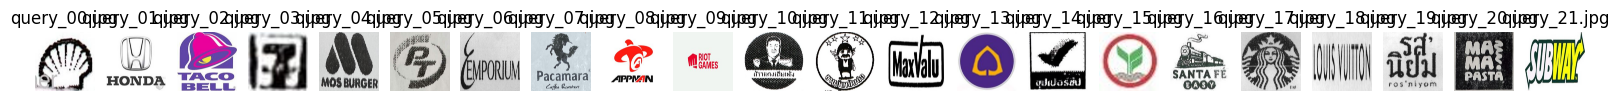

In [5]:
fig , axes = plt.subplots(1 , 22 , figsize = (20,  20))

for idx , path in enumerate(queries_path) :
    
    image = Image.open(path)
    image = image.resize((1024 , 1024))
    
    axes[idx].imshow(image)
    axes[idx].set_title(path.split('\\')[-1])
    axes[idx].axis('off')

### Test Image

In [6]:
test_path = glob.glob('./datasets/test/images/*')

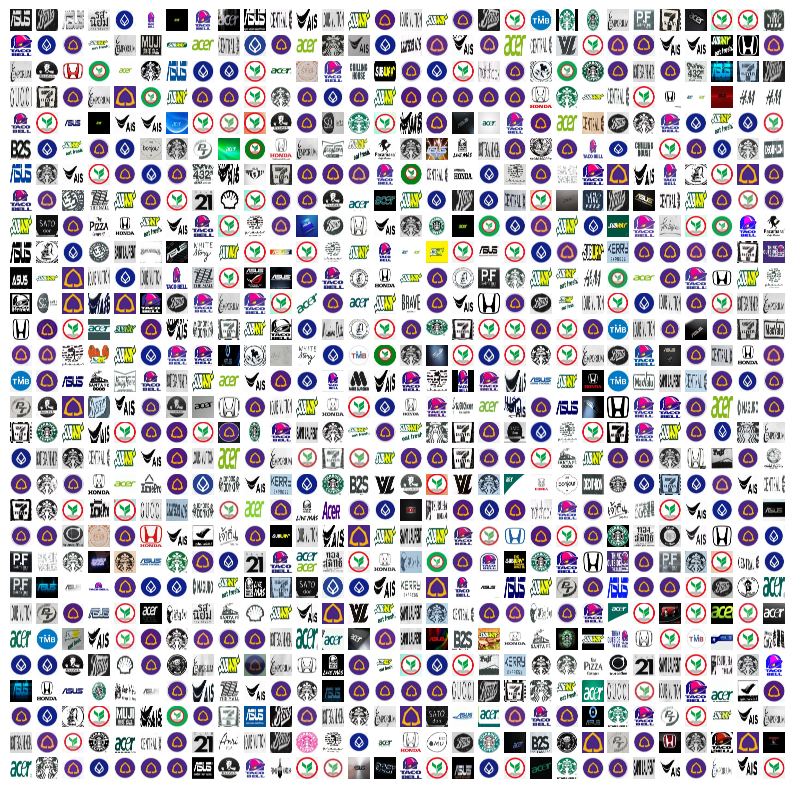

In [7]:
num_row = 30
num_column = 30

fig , axes = plt.subplots(num_row , num_column , figsize = (10 , 10))

for idx , path in enumerate(test_path[ : num_row * num_column]) :
    
    image = Image.open(path)
    image = image.resize((512 , 512))
    
    axes[idx // num_column, idx % num_column].imshow(image)
    axes[idx // num_column, idx % num_column].axis('off')

## CLIP 

In [8]:
from transformers import AutoProcessor, CLIPVisionModel

c:\anaconda\envs\image_search\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")
processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [10]:
queries_path = glob.glob('./datasets/queries/queries/*')
images = [Image.open(file_path) for file_path in queries_path]

In [11]:
query_inputs = processor(images = images , return_tensors = 'pt')

In [12]:
outputs = model(**query_inputs)

In [13]:
len(outputs.last_hidden_state)

22